In [390]:
import os
import numpy as np
import scipy.misc as smp
import matplotlib.colors
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cv2
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import ProcessPoolExecutor
from IPython import display
from IPython.display import clear_output
import pydotplus

In [ ]:
PROJECT_ROOT_DIR = os.getcwd()
print('Project is located at', PROJECT_ROOT_DIR)

In [16]:
# Visualization tool to help the wait time not feel as long
def update_progress(progress, name='Progress'):
    # Progress bar from https://www.mikulskibartosz.name/how-to-display-a-progress-bar-in-jupyter-notebook/
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait=True)
    text = "{2}: [{0}] {1:.1f}%".format(
        "#" * block + "-" * (bar_length - block), progress * 100, name)
    print(text)

In [403]:
# checking to make sure I am in the right directory
pwd

'/Users/csega/Documents/CSE-570/spring2020ml-predictingvirusbodyload/Milestone1/Precharattana Model'

In [ ]:
import Model

# Runs through one replication of an L size matrix with a certain number of timesteps
Model.run(timesteps=600, L=800, replications=100)

In [180]:
FOLDER_NAME = '03-24-2020 10.07.51'
os.chdir(FOLDER_NAME)

In [19]:
# Precharattana Model constants

CELL_H   = 0
CELL_A2  = 1
CELL_A0  = 2
CELL_A1  = 4
CELL_D   = 8

mycmap = {
    CELL_H: [255, 255, 255],
    CELL_A2: [0, 255, 0],
    CELL_A0: [128, 128, 0],
    CELL_A1: [0, 128, 0],
    CELL_D: [0, 0, 0], 
}

names = {
    CELL_H: 'Healthy',
    CELL_A2: 'Stage 1 Infected',
    CELL_A0: 'Latent Infected',
    CELL_A1: 'Stage 2 Infected', 
    CELL_D: 'Dead', 
}

In [20]:
def plotFrame(run, t):

    picture = np.load(str(run) + '/' + str(t) + '.npz')['arr_0']
    # Create a 800x800x3 array of 8 bit unsigned integers
    data = np.zeros((800,800,3), dtype=np.uint8)
    # Convert picture array to image
    for row in range(0, len(data)):
        for col in range(0, len(data)):
            data[row][col] = mycmap[picture[row][col]]
    
    fig, ax = plt.subplots(figsize=(10, 10))
    im = plt.imshow(data)
    
    colors = {k:im.cmap(im.norm(k)) for k in names.keys()}
    # create a patch (proxy artist) for every color 
    patches = [mpatches.Patch(color=list(map(lambda x : x / 255, mycmap[k])), label=names[k]) for k in names.keys()]
    # put those patched as legend-handles into the legend
    plt.legend(handles=patches, bbox_to_anchor=(1, 1), loc=2, borderaxespad=0. )

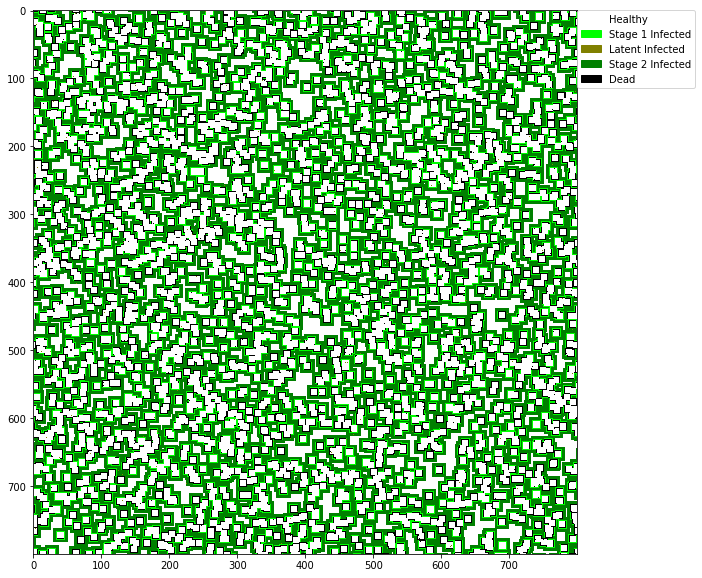

In [181]:
for i in range(10,11):
    display.clear_output(wait=True)
    plotFrame(1, i)

In [21]:
# Helper function that converts a raw simulation result into an image operable
# by the OpenCV library.
def gridToOpenCVImage(grid):
    # Create a L by L by 3 np array
    res = np.zeros([*grid.shape, 3], dtype=np.uint8)
    
    # trnasform grid into a format with an rgb component
    for row in range(len(grid)):
        for col in range(len(grid[0])):
            # Gets the color in mycmap and reverse it to BGR
            res[row][col] = mycmap[grid[row][col]][::-1]
    
    return res

In [22]:
def getAvgDistance(keypoints):
    if keypoints == []:
        return 0
    
    N = len(keypoints)
    res = 0
    
    for kpi in keypoints:
        for kpj in keypoints:
            x1, y1 = kpi.pt
            x2, y2 = kpj.pt
            res += np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
    
    return res / (2 * N)

In [23]:
def getAvgSize(keypoints):
    if keypoints == []:
        return 0
    
    return np.average([kp.size for kp in keypoints])

In [24]:
# Helper function to run the SimpleBlobDetector algorithm on a given image.
# Return all found blobs with minimum area selected by input.
def getKeypoints(im, area):
    params = cv2.SimpleBlobDetector_Params()
    
    params.minThreshold = 1
    params.maxThreshold = 200
    
    params.filterByArea = True
    params.minArea = area

    params.filterByCircularity = False
    params.filterByConvexity = False
    params.filterByInertia = False
    
    detector = cv2.SimpleBlobDetector_create(params)
    return detector.detect(im)

In [25]:
# Returns all the 6 features from each image. The format of return is a 1x6
# numpy array with fields [num, dist, avg size, num, dist, avg size] where
# the first 3 correspond to keypoints obtained when minArea = 5
def getFeatures(im):
    keypoints_5 = getKeypoints(im, 5)
    keypoints_10 = getKeypoints(im, 10)
    
    return np.array([
        len(keypoints_5), getAvgDistance(keypoints_5), getAvgSize(keypoints_5),
        len(keypoints_10), getAvgDistance(keypoints_10), getAvgSize(keypoints_10),
    ])

In [26]:
def getSubDirs():
    return [os.path.join(os.getcwd(), d) for d in os.listdir() 
            if os.path.isdir(os.path.join(os.getcwd(), d)) 
            and not d == '__pycache__']

In [28]:
# Make sure directory is correct

In [173]:
pwd

'/Users/csega/Documents/CSE-570/spring2020ml-predictingvirusbodyload/Milestone1/Precharattana Model/03-24-2020 10.07.51'

In [174]:
L = len(getSubDirs())
print("L:",L)
    
# Read in the prevelance of states csv
prevelance_df = pd.read_csv("prevelance.csv")
feature_df = pd.DataFrame(np.zeros([L, 6]), 
                          columns=['5_num', '5_avg_dist', '5_avg_size', 
                                   '10_num', '10_avg_dist', '10_avg_size'])

# For each run, load the t=10 np array and extract all features
for run_dir, run in zip(getSubDirs(), range(L)):
    update_progress(run / L)
    os.chdir(run_dir)
    im = gridToOpenCVImage(np.load('10.npz')['arr_0'])
    feature_df.iloc[run] = getFeatures(im)
    update_progress((run + 1) / L)
opencvArr = pd.DataFrame(pd.merge(feature_df, prevelance_df, left_index=True, right_index=True))

opencvArr = opencvArr.reset_index().drop('index', axis=1)

os.chdir("../")
opencvArr.to_csv('openCVPrevelance.csv',index=False)

Progress: [####################] 100.0%


In [384]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from IPython.display import SVG, display
from graphviz import Source
from sklearn.tree import export_graphviz

In [364]:
# Decision Tree Regressor

data = opencvArr[opencvArr.columns[:6]]

answer = opencvArr[opencvArr.columns[6:]]

# Turns answer into percentage
answer=np.true_divide(answer, 64e4)

data_train, data_test, answer_train, answer_test = train_test_split(data, answer)

data_train = data_train.reset_index().drop('index', axis=1)
data_test = data_test.reset_index().drop('index', axis=1)
answer_train = answer_train.reset_index().drop('index', axis=1)
answer_test = answer_test.reset_index().drop('index', axis=1)
tree_reg = DecisionTreeRegressor()
tree_reg.fit(data_train, answer_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [365]:
answer_predict =  pd.DataFrame(tree_reg.predict(data_test), columns=['H','A','0','D'])
tree_mse = np.mean((answer_test - answer_predict)**2)
print("Mean Square Error for each Category")
print(mse)

Mean Square Error for each Category
H    1.003489e-07
A    3.545090e-07
0    3.074631e-07
D    9.730614e-08
dtype: float64


The regression quality using mean square error is really close to the actual results. The tree was able to take in the test inputs and return an expected outcome that was very close to the test results. The error mean square error between the expected results and the recorded results are significantley less than one.

In [366]:
# The two values tables below are one ones compared above. The answer_test was the one 
# generated in the test while the answer_predict is the predicted answer
answer_test

H         A         0         D
0   0.137358  0.685836  0.038664  0.138142
1   0.138366  0.684223  0.037547  0.139864
2   0.137380  0.685506  0.038630  0.138484
3   0.137402  0.685552  0.038988  0.138059
4   0.137873  0.686619  0.036748  0.138759
5   0.137673  0.686181  0.037867  0.138278
6   0.136931  0.685881  0.038670  0.138517
7   0.137455  0.686442  0.037577  0.138527
8   0.138120  0.686562  0.036784  0.138533
9   0.138506  0.684519  0.038598  0.138377
10  0.137141  0.686725  0.037572  0.138563
11  0.137550  0.685622  0.037920  0.138908
12  0.137612  0.686389  0.037516  0.138483
13  0.138033  0.685967  0.037017  0.138983
14  0.138264  0.685022  0.037681  0.139033
15  0.136995  0.685864  0.038344  0.138797
16  0.137952  0.684997  0.038723  0.138328
17  0.137802  0.685175  0.037928  0.139095
18  0.138233  0.684850  0.037880  0.139038
19  0.137687  0.685252  0.038645  0.138416
20  0.138469  0.684973  0.037945  0.138612
21  0.138253  0.685784  0.038044  0.137919
22  0.137506  0.685705  0.038480  0.138309
23  0.137931  0.685542  0.037677  0.138850
24  0.137992  0.685630  0.037661  0.138717

In [367]:
answer_predict

H         A         0         D
0   0.137933  0.685002  0.037605  0.139461
1   0.137933  0.685002  0.037605  0.139461
2   0.137094  0.685433  0.039559  0.137914
3   0.137503  0.684981  0.038500  0.139016
4   0.138489  0.685276  0.037405  0.138830
5   0.136859  0.687558  0.037088  0.138495
6   0.137705  0.685512  0.037734  0.139048
7   0.137678  0.684992  0.038647  0.138683
8   0.137678  0.684992  0.038647  0.138683
9   0.137791  0.685359  0.037378  0.139472
10  0.137094  0.685433  0.039559  0.137914
11  0.138205  0.684780  0.038443  0.138571
12  0.136527  0.687445  0.038345  0.137683
13  0.137514  0.685676  0.038488  0.138321
14  0.137431  0.686541  0.037134  0.138894
15  0.137812  0.685732  0.037897  0.138559
16  0.137623  0.686274  0.037541  0.138562
17  0.137762  0.685292  0.038481  0.138465
18  0.137327  0.686617  0.037034  0.139022
19  0.137707  0.686320  0.037402  0.138572
20  0.138205  0.684780  0.038443  0.138571
21  0.137804  0.686632  0.036726  0.138838
22  0.137514  0.685676  0.038488  0.138321
23  0.137125  0.686167  0.038687  0.138020
24  0.137882  0.686741  0.037358  0.138020

In [395]:
# create thes visualization of the tree
data_columns = ['5_num', '5_avg_dist', '5_avg_size', '10_num', '10_avg_dist', '10_avg_size']
answer_columns = ['H', 'A', '0', 'D']
graph = export_graphviz(tree_reg, 
                               out_file=None, 
                               feature_names=data_columns, 
                               class_names=answer_columns, 
                               filled=True)


In [397]:
# Change back to project directory before saving
os.chdir("../")
pydot_graph = pydotplus.graph_from_dot_data(graph)
pydot_graph.write_png('Preharattana_Model_Tree.png')

True

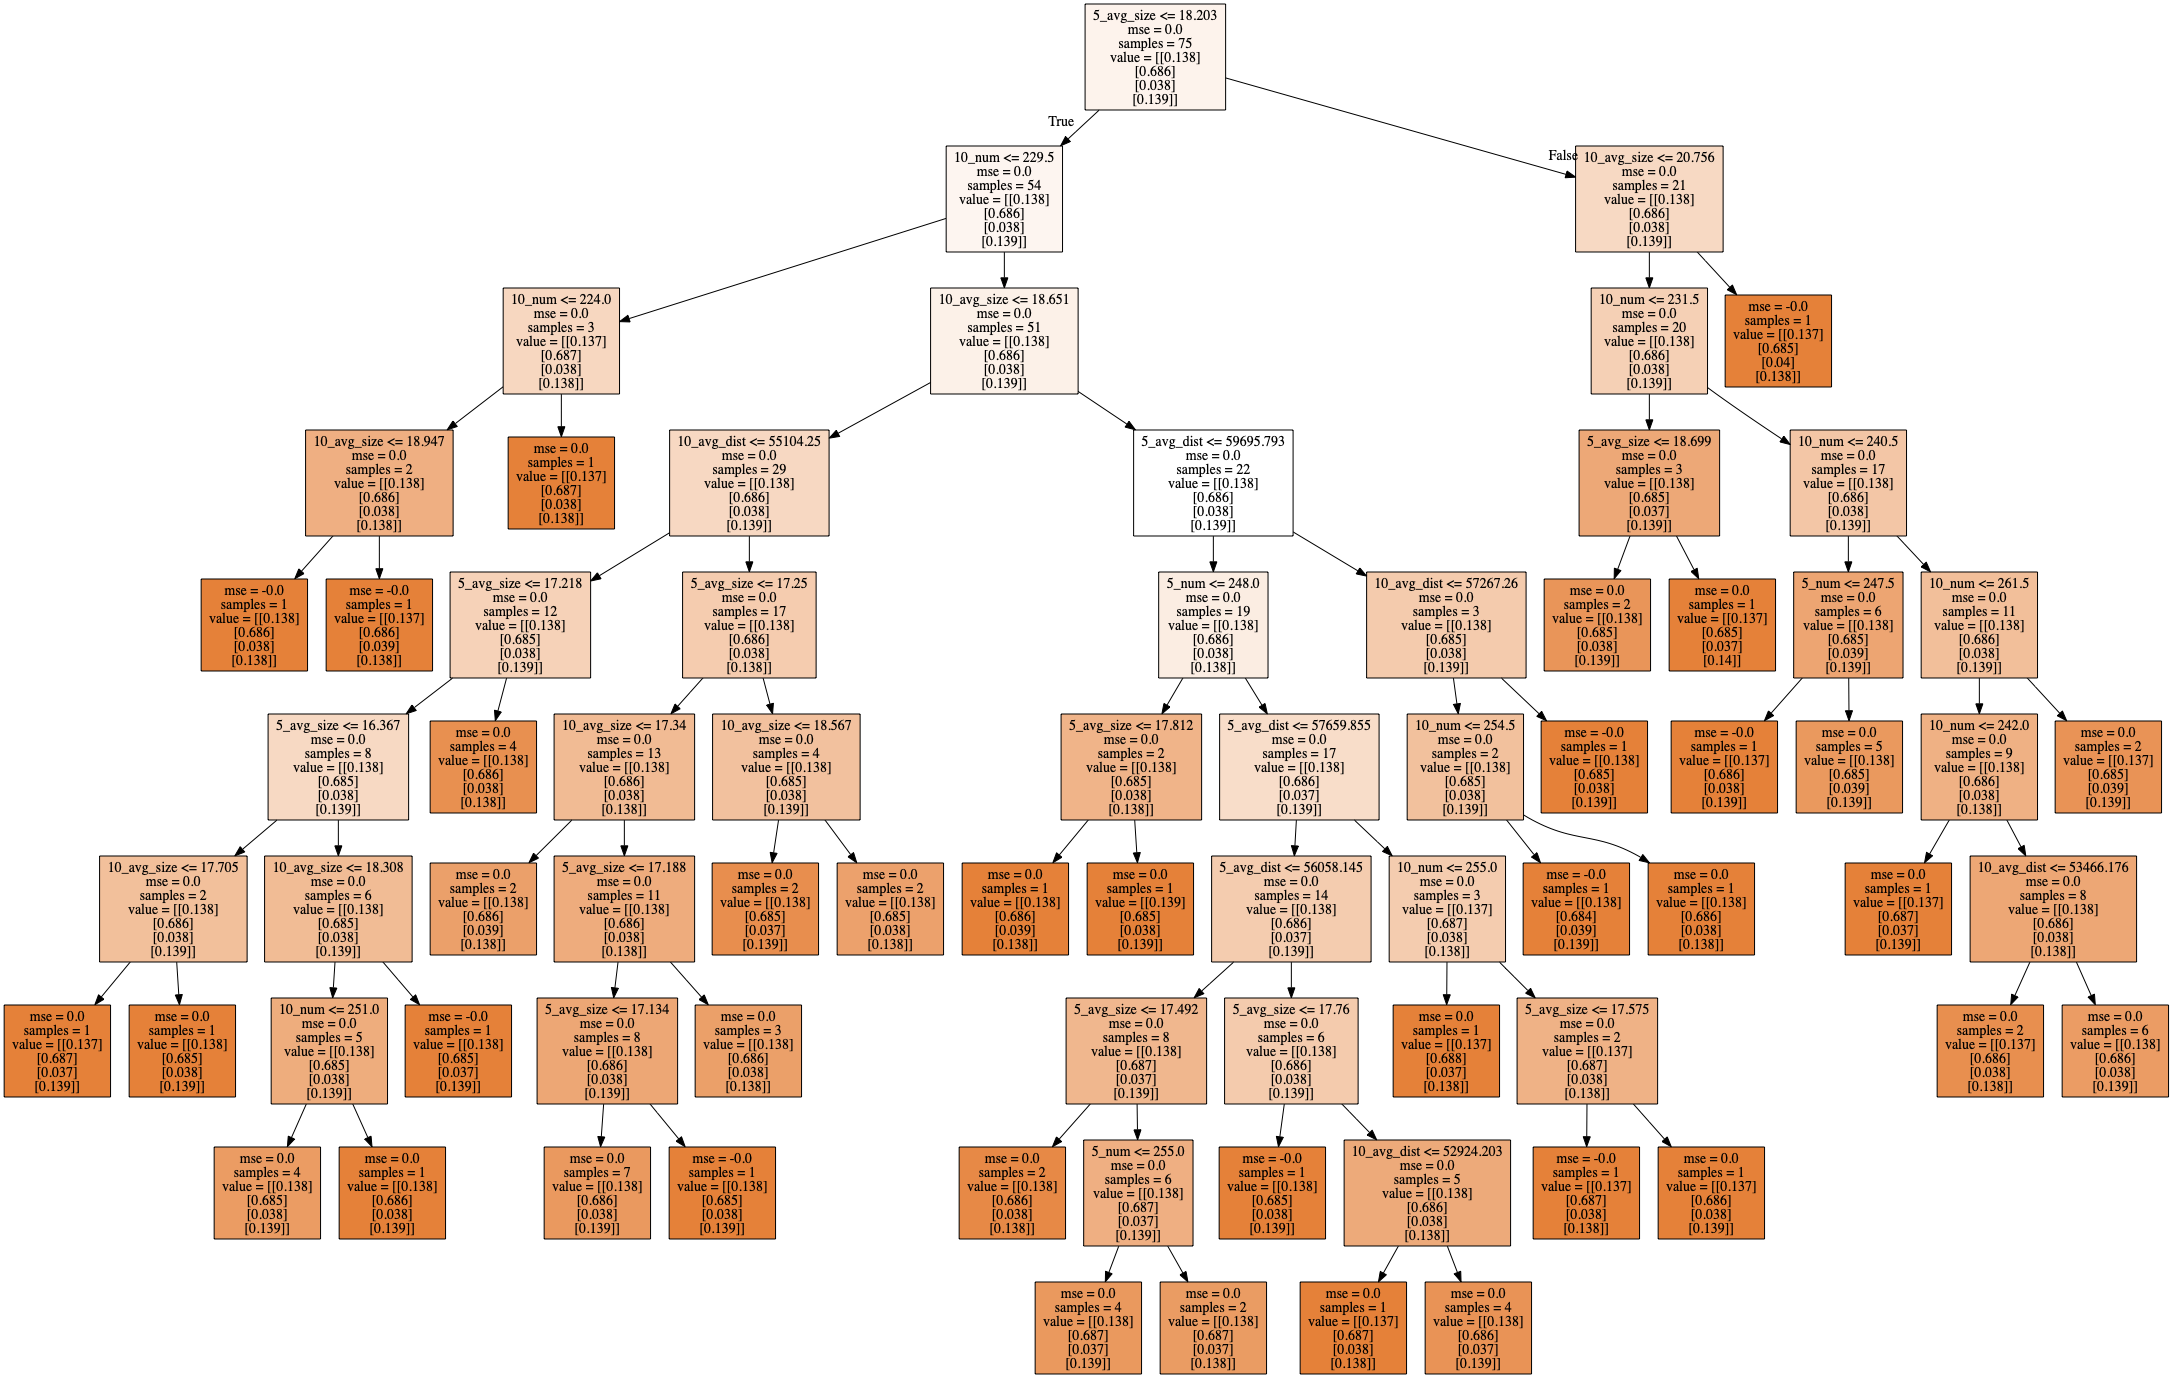

In [399]:
# display tree
from IPython.display import Image
Image(filename='Preharattana_Model_Tree.png') 